In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

from lime.lime_tabular import LimeTabularExplainer

# Import and init shap
import shap
shap.initjs()
import joblib, os

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [3]:
## Load the joblib file stored in the models folder
fname = "Models/best-models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [5]:
## Get feature names from already-fit preprocessor

feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8269        7.220         0.064142   61.2510                     1998.0   
7604        6.135         0.079294  111.2860                     2009.0   
2762       12.150         0.028593  151.0708                     2004.0   
6464        5.945         0.093009  127.8652                     2004.0   
4707       18.200         0.066285  247.2092                     2004.0   

      Item_Identifier_DRA12  Item_Identifier_DRA24  Item_Identifier_DRA59  \
8269                    0.0                    0.0                    0.0   
7604                    0.0                    0.0                    0.0   
2762                    0.0                    0.0                    0.0   
6464                    0.0                    0.0                    0.0   
4707                    0.0                    0.0                    0.0   

      Item_Identifier_DRB01  Item_Identifier_DRB13  Item_Identifier_DRB24  \
8269                    0.0                    0.0                    0.0   
7604                    0.0                    0.0                    0.0   
2762                    0.0                    0.0                    0.0   
6464                    0.0                    0.0                    0.0   
4707                    0.0                    0.0                    0.0   

      ...  Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
8269  ...                  1.0                 0.0                0.0   
7604  ...                  0.0                 1.0                0.0   
2762  ...                  0.0                 0.0                1.0   
6464  ...                  0.0                 0.0                1.0   
4707  ...                  0.0                 0.0                1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8269                          0.0                          0.0   
7604                          0.0                          0.0   
2762                          0.0                          1.0   
6464                          0.0                          1.0   
4707                          0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8269                          1.0                        1.0   
7604                          1.0                        0.0   
2762                          0.0                        0.0   
6464                          0.0                        0.0   
4707                          0.0                        0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
8269                            0.0                            0.0   
7604                            0.0                            1.0   
2762                            1.0                            0.0   
6464                            1.0                            0.0   
4707                            1.0                            0.0   

      Outlet_Type_Supermarket Type3  
8269                            0.0  
7604                            0.0  
2762                            0.0  
6464                            0.0  
4707                            0.0  

[5 rows x 1597 columns]

In [6]:
len(X_train_df)

6392

In [7]:
preprocessor.fit(X_train_df,y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ec04dc0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ec04790>)],
                  verbose_feature_names_out=False)

## Global Explanations

In [8]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_df, nsamples = 100,random_state=SEED)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4469         7.72         0.074669   76.3986                     1987.0   
4438         5.11         0.034868  163.8210                     2004.0   
366          8.05         0.078386  256.4646                     2004.0   
2219         8.76         0.050131  128.3336                     1999.0   
6080         6.59         0.176748   82.7908                     1998.0   

      Item_Identifier_DRA12  Item_Identifier_DRA24  Item_Identifier_DRA59  \
4469                    0.0                    0.0                    0.0   
4438                    0.0                    0.0                    0.0   
366                     0.0                    0.0                    0.0   
2219                    0.0                    0.0                    0.0   
6080                    0.0                    0.0                    0.0   

      Item_Identifier_DRB01  Item_Identifier_DRB13  Item_Identifier_DRB24  \
4469                    0.0                    0.0                    0.0   
4438                    0.0                    0.0                    0.0   
366                     0.0                    0.0                    0.0   
2219                    0.0                    0.0                    0.0   
6080                    0.0                    0.0                    0.0   

      ...  Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
4469  ...                  0.0                 0.0                0.0   
4438  ...                  0.0                 0.0                1.0   
366   ...                  0.0                 0.0                1.0   
2219  ...                  0.0                 1.0                0.0   
6080  ...                  1.0                 0.0                0.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4469                          0.0                          0.0   
4438                          0.0                          1.0   
366                           0.0                          1.0   
2219                          1.0                          0.0   
6080                          0.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4469                          1.0                        0.0   
4438                          0.0                        0.0   
366                           0.0                        0.0   
2219                          0.0                        0.0   
6080                          1.0                        1.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4469                            1.0                            0.0   
4438                            1.0                            0.0   
366                             1.0                            0.0   
2219                            1.0                            0.0   
6080                            0.0                            0.0   

      Outlet_Type_Supermarket Type3  
4469                            0.0  
4438                            0.0  
366                             0.0  
2219                            0.0  
6080                            0.0  

[5 rows x 1597 columns]

In [9]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
8373    2051.9956
5234    1504.7080
4523    3374.2744
2963     397.4826
5753    1662.5026
Name: Item_Outlet_Sales, Length: 100, dtype: float64

In [10]:
X_shap.shape

(100, 1597)

In [11]:
# Instantiate a Model Explainer with the model
explainer =shap.TreeExplainer(rf_reg)
explainer

In [12]:
## Getting the shap values
shap_values = explainer.shap_values(X_shap,y_shap,check_additivity=False)
type(shap_values)

numpy.ndarray

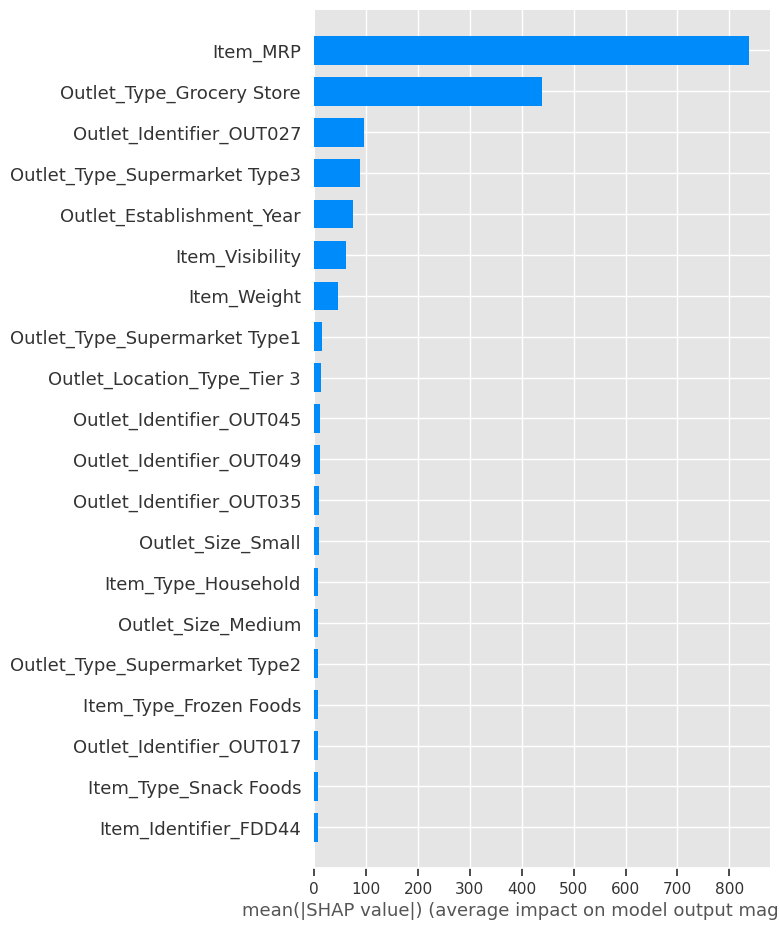

In [13]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


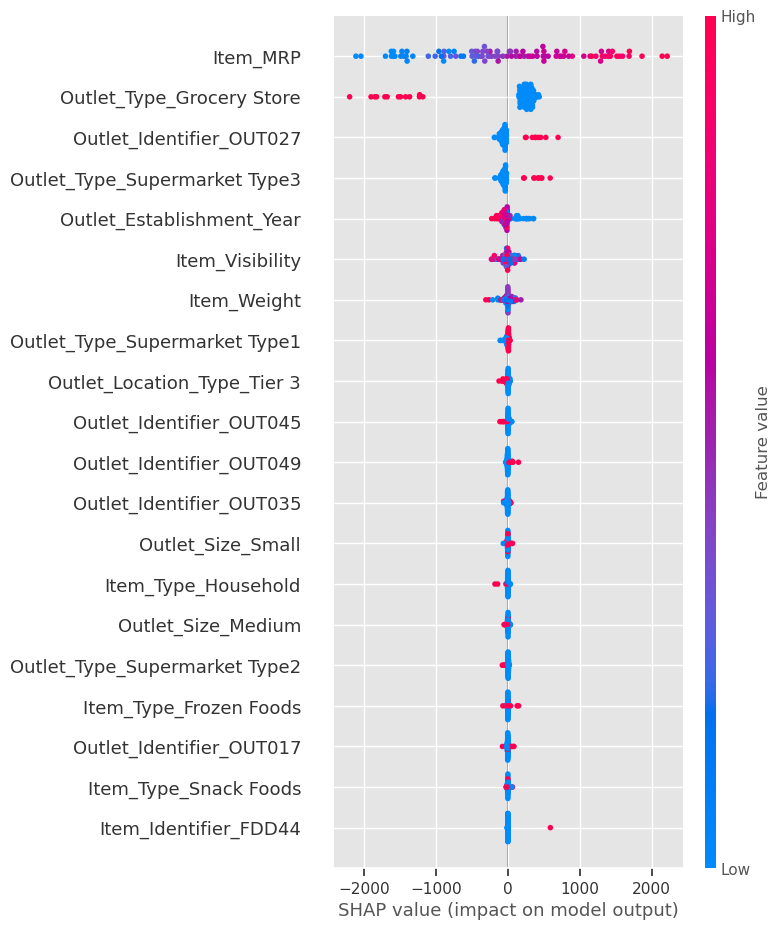

<Figure size 640x480 with 0 Axes>

In [14]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)
plt.savefig('global_summary_plot.png')

- Top 5 Important Features:
    - Item MRP
        - The higher item MRP the more likely the model will predict a higher Item Outlet Sale
    - Outlet Type Grocery Store
        - Being classified as Outlet type grocery store decreased the likelihood the model will predict a higher Item Outlet Sale
    - Outlet Identifier OUT027
        - Outlet identifier OUT027 indicates that the model will predict a higher Item Outlet Sale.
    - Outlet Type Supermarket Type3
        - Outlet type supermaket type3 indicaates that the model will predict a higher Item Outlet Sale.
    - Outlet Establishment Year
        - The lower outlet establishment year, the more liekly the model will predict a higher Item Outlet Sale.

![png](Feature_Importance_Decision_Tree_Regressor.png)

- Three of five top features are listed in both the feature importance plot and the global shap summary plot.

## Local Explanations

### High Item MRP

In [15]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0         7.72         0.074669   76.3986                     1987.0   
1         5.11         0.034868  163.8210                     2004.0   
2         8.05         0.078386  256.4646                     2004.0   
3         8.76         0.050131  128.3336                     1999.0   
4         6.59         0.176748   82.7908                     1998.0   

   Item_Identifier_DRA12  Item_Identifier_DRA24  Item_Identifier_DRA59  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   Item_Identifier_DRB01  Item_Identifier_DRB13  Item_Identifier_DRB24  ...  \
0                    0.0                    0.0                    0.0  ...   
1                    0.0                    0.0                    0.0  ...   
2                    0.0                    0.0                    0.0  ...   
3                    0.0                    0.0                    0.0  ...   
4                    0.0                    0.0                    0.0  ...   

   Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                1.0   
2                  0.0                 0.0                1.0   
3                  0.0                 1.0                0.0   
4                  1.0                 0.0                0.0   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                          0.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          1.0   
3                          1.0                          0.0   
4                          0.0                          0.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                          1.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          1.0                        1.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            1.0                            0.0   
1                            1.0                            0.0   
2                            1.0                            0.0   
3                            1.0                            0.0   
4                            0.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 1597 columns]

In [16]:
# what is the max/range of infant deaths
X_shap_local['Item_MRP'].describe()

count    100.000000
mean     136.675584
std       63.159380
min       35.287400
25%       88.184300
50%      131.961300
75%      178.483750
max      262.893600
Name: Item_MRP, dtype: float64

In [17]:
## saving the index of the most deaths
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

54

In [18]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_MRP]

Item_Weight                        13.650000
Item_Visibility                     0.080766
Item_MRP                          262.893600
Outlet_Establishment_Year        1999.000000
Item_Identifier_DRA12               0.000000
                                    ...     
Outlet_Location_Type_Tier 3         0.000000
Outlet_Type_Grocery Store           0.000000
Outlet_Type_Supermarket Type1       1.000000
Outlet_Type_Supermarket Type2       0.000000
Outlet_Type_Supermarket Type3       0.000000
Name: 54, Length: 1597, dtype: float64

In [19]:
## what was the actual life expectancy?
y_shap_local.iloc[idx_high_MRP]

4958.8784

In [29]:
## plotting example force plot for most inf.deaths (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_MRP],
               features=X_shap_local.iloc[idx_high_MRP])

- There are more features that have a positive impact on the model increasing the predicted item outlet sale.

In [21]:
## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [22]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_MRP],
                                      rf_reg.predict)
exp.show_in_notebook()
plt.savefig('high_mrp_tabular_plot.png')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 640x480 with 0 Axes>

- There are multiple features that had a negative impact on the item outlet sale, but there four features that had a stronger positive impact on the predicted item outlet sale.

### Low Item MRP

In [23]:
## saving the index of the most deaths
idx_low_MRP = X_shap_local['Item_MRP'].idxmin()
idx_low_MRP

80

In [24]:
# checking the feature values for selected example
X_shap_local.iloc[idx_low_MRP]

Item_Weight                        12.822634
Item_Visibility                     0.110736
Item_MRP                           35.287400
Outlet_Establishment_Year        1985.000000
Item_Identifier_DRA12               0.000000
                                    ...     
Outlet_Location_Type_Tier 3         1.000000
Outlet_Type_Grocery Store           0.000000
Outlet_Type_Supermarket Type1       0.000000
Outlet_Type_Supermarket Type2       0.000000
Outlet_Type_Supermarket Type3       1.000000
Name: 80, Length: 1597, dtype: float64

In [25]:
## what was the actual life expectancy?
y_shap_local.iloc[idx_low_MRP]

988.0472

In [31]:
## plotting example force plot for most inf.deaths (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_low_MRP],
               features=X_shap_local.iloc[idx_low_MRP])

- Item_MRP had a more negative impact on the model decreasing the predicted item outlet sale.

In [27]:
## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [28]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_MRP],
                                      rf_reg.predict)
exp.show_in_notebook()
plt.savefig('low_mrp_tabular_plot.png')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 640x480 with 0 Axes>

- There are several factors that have a positive impact on the predicted item outlet sale, but there are several factors that have a stronger negative impact to decrease the predicted item outlet sale.